# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In [33]:
import cv2
import keras.layers as layers
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.utils import shuffle

---
## Step 0: Load The Data

In [34]:
# Load pickled data
import pickle
import csv

training_file = "../traffic-signs-data/train.p"
validation_file = "../traffic-signs-data/valid.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [35]:
# Read sign names from csv file
class_names = {}
with open('signnames.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        class_names[row[0]] = row[1]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [36]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of a traffic sign image
image_shape = X_test[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

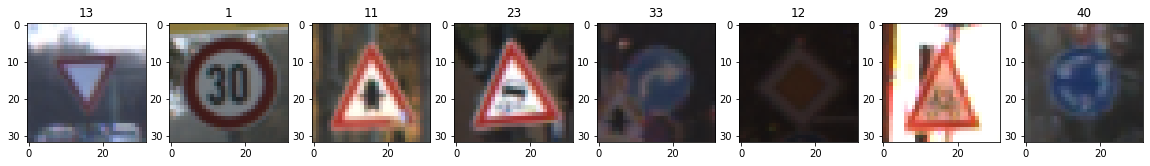

In [37]:
# Data exploration visualization

import matplotlib.pyplot as plt
import random
%matplotlib inline


#  Let's see 8 random imagaes from the dataset
indexes = [random.randint(0, len(X_train)) for i in range(8)]
fig, axs = plt.subplots(1,8, figsize=(20,5))

for i in range(8):
    axs[i].imshow(X_train[indexes[i]])
    axs[i].set_title(y_train[indexes[i]])



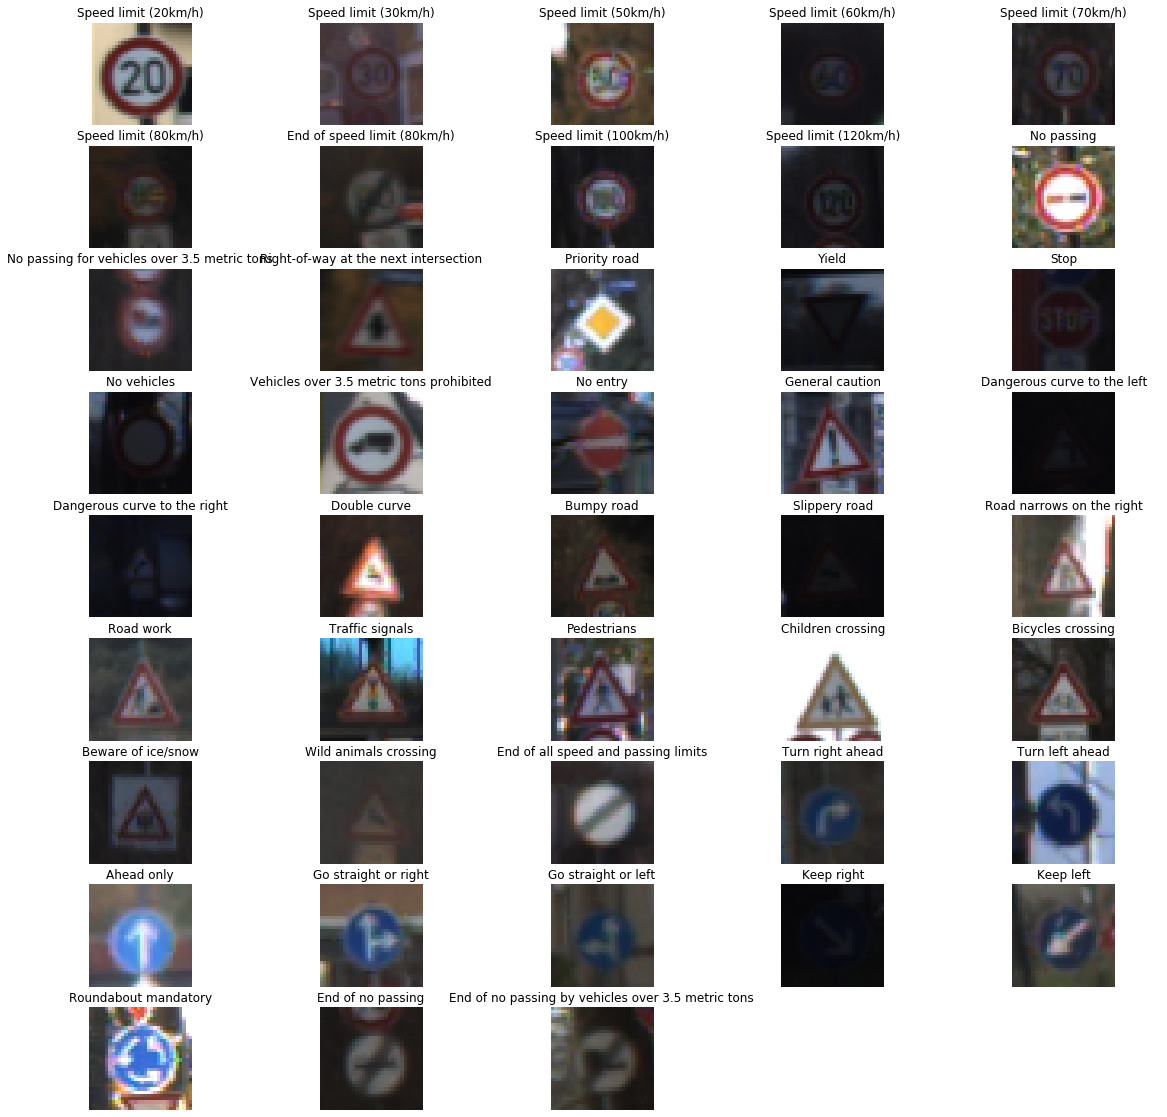

In [38]:
# Let's see one image from each class
fig, axs = plt.subplots(9,5, figsize=(20,20))

for i in range(45):
    axs[i//5,i%5].axis('off')
    if i < 43:
        axs[i//5,i%5].set_title(class_names[str(i)])
        ind = list(y_train).index(i)
        axs[i//5,i%5].imshow(X_train[ind])
    
plt.savefig('./output_images/data_exploration_signs.jpg')



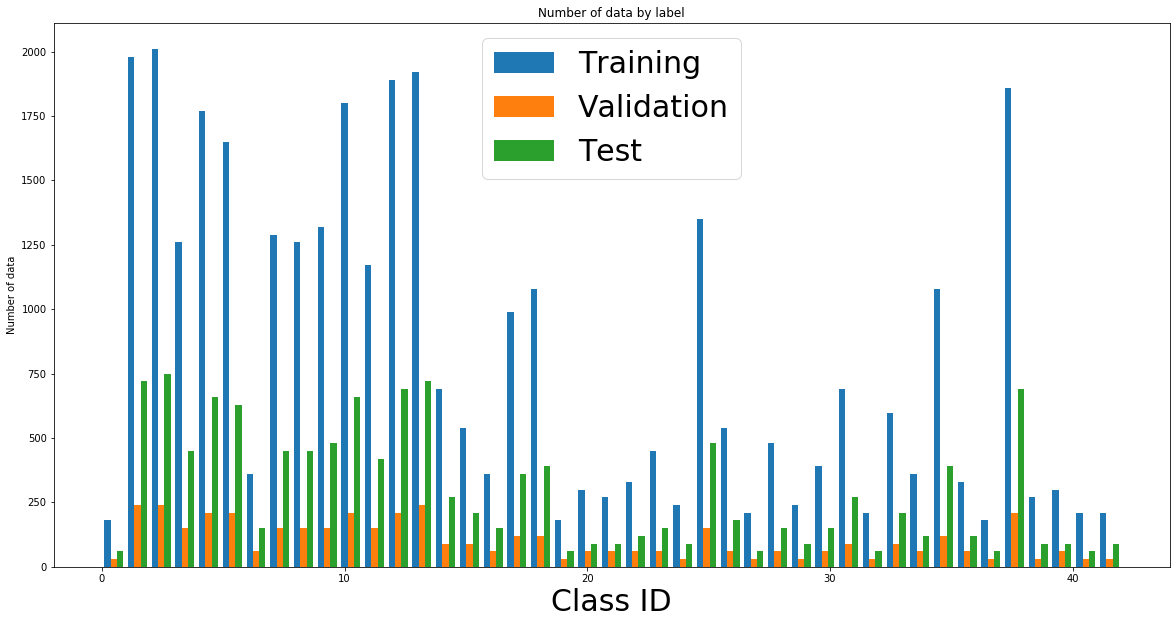

In [43]:
# The histogram of the labels in the data set
fig, ax = plt.subplots(figsize=(20,10))

x_multi = [y_train, y_valid, y_test]
labels = ['Training', 'Validation', 'Test']

ax.hist(x_multi, 43,histtype='bar', label=labels)
ax.set_title('Number of data by label')
ax.legend(prop={'size': 30})
plt.xlabel('Class ID', fontsize=30)
plt.ylabel('Number of data')

plt.savefig('./output_images/number_data_by_label.jpg')

In [8]:
# Print class names
for i in range(43):
    print('Class ' + str(i) + ': '+ class_names[str(i)])

Class 0: Speed limit (20km/h)
Class 1: Speed limit (30km/h)
Class 2: Speed limit (50km/h)
Class 3: Speed limit (60km/h)
Class 4: Speed limit (70km/h)
Class 5: Speed limit (80km/h)
Class 6: End of speed limit (80km/h)
Class 7: Speed limit (100km/h)
Class 8: Speed limit (120km/h)
Class 9: No passing
Class 10: No passing for vehicles over 3.5 metric tons
Class 11: Right-of-way at the next intersection
Class 12: Priority road
Class 13: Yield
Class 14: Stop
Class 15: No vehicles
Class 16: Vehicles over 3.5 metric tons prohibited
Class 17: No entry
Class 18: General caution
Class 19: Dangerous curve to the left
Class 20: Dangerous curve to the right
Class 21: Double curve
Class 22: Bumpy road
Class 23: Slippery road
Class 24: Road narrows on the right
Class 25: Road work
Class 26: Traffic signals
Class 27: Pedestrians
Class 28: Children crossing
Class 29: Bicycles crossing
Class 30: Beware of ice/snow
Class 31: Wild animals crossing
Class 32: End of all speed and passing limits
Class 33: Tur

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Our goal is to have validation set accuracy of at least 0.93. 

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 255` is a quick way to approximately normalize the data and can be used in this project. 

In [9]:
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

# Convert to grayscale and Normalize the data

XX_train = np.zeros(shape=(len(X_train),32, 32, 1))
for i in range(len(X_train)):
    gray_image = cv2.cvtColor(X_train[i,:,:,:], cv2.COLOR_RGB2GRAY)
    XX_train[i,:,:,0] = gray_image / 255.0 - 0.5

XX_valid = np.zeros(shape=(len(X_valid),32, 32, 1))
for i in range(len(X_valid)):
    gray_image = cv2.cvtColor(X_valid[i,:,:,:], cv2.COLOR_RGB2GRAY) 
    XX_valid[i,:,:,0] = gray_image / 255.0 - 0.5

XX_test = np.zeros(shape=(len(X_test),32, 32, 1))
for i in range(len(X_test)):
    gray_image = cv2.cvtColor(X_test[i,:,:,:], cv2.COLOR_RGB2GRAY) 
    XX_test[i,:,:,0] = gray_image / 255.0 - 0.5

X_train = XX_train
X_valid = XX_valid
X_test = XX_test

# Convert class numbers to binary class matrices
y_train_one_hot = tf.one_hot(y_train, 43)
y_valid_one_hot = tf.one_hot(y_valid, 43)
y_test_one_hot = tf.one_hot(y_test, 43)


### Model Architecture

In [10]:
# LeNet architecture
EPOCHS = 25
BATCH_SIZE = 128 
LEARNING_RATE = 0.001

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPool2D(strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=43, activation = 'softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dropout (Dropout)            (None, 120)               0

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
# Train the model
history = model.fit(X_train, y_train_one_hot, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_valid, y_valid_one_hot))

Train on 34799 samples, validate on 4410 samples
Epoch 1/25
34799/34799 [==============================] - 8s 234us/sample - loss: 2.5979 - accuracy: 0.2979 - val_loss: 1.2878 - val_accuracy: 0.6510
Epoch 2/25
34799/34799 [==============================] - 8s 238us/sample - loss: 1.0393 - accuracy: 0.6838 - val_loss: 0.6211 - val_accuracy: 0.8215
Epoch 3/25
34799/34799 [==============================] - 8s 225us/sample - loss: 0.6335 - accuracy: 0.8091 - val_loss: 0.4292 - val_accuracy: 0.8830
Epoch 4/25
34799/34799 [==============================] - 8s 225us/sample - loss: 0.4615 - accuracy: 0.8619 - val_loss: 0.3363 - val_accuracy: 0.9029
Epoch 5/25
34799/34799 [==============================] - 8s 232us/sample - loss: 0.3526 - accuracy: 0.8950 - val_loss: 0.2939 - val_accuracy: 0.9193
Epoch 6/25
34799/34799 [==============================] - 8s 229us/sample - loss: 0.2943 - accuracy: 0.9118 - val_loss: 0.2632 - val_accuracy: 0.9286
Epoch 7/25
34799/34799 [===========================

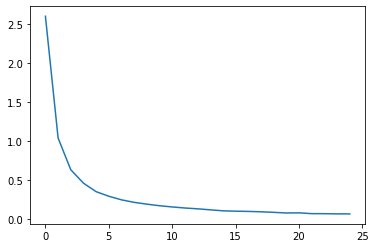

In [14]:
plt.plot(history.history['loss'])

In [15]:
# Evaluate the model
metrics = model.evaluate(X_test, y_test_one_hot, verbose=0)

for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))
    

loss: 0.452624461626721
accuracy: 0.9296120405197144


---

## Step 3: Test a Model on New Images

To get more insight into how the model is working, we downloaded at five pictures of German traffic signs from the web and use the model to predict the traffic sign type.

The file `signnames.csv` contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

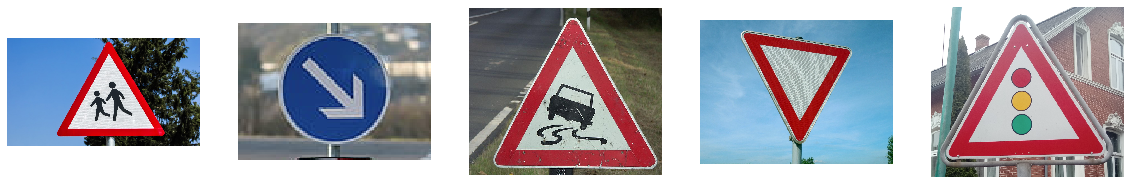

In [16]:
### Load the images and plot
new_images = []
new_images.append(cv2.imread('test_images/children crossing.jpg'))
new_images.append(cv2.imread('test_images/keep right.jpg'))
new_images.append(cv2.imread('test_images/slippery road.jpg'))
new_images.append(cv2.imread('test_images/yield.jpg'))
new_images.append(cv2.imread('test_images/traffic signals.jpg'))
new_images.append(cv2.imread('test_images/puppy.jpg'))


new_test = {}
new_test['features'] = np.array(new_images)
new_test['labels'] = [28, 38, 23, 13, 26]

fig, axs = plt.subplots(1,5, figsize=(20,5))

for i in range(5):
    img = cv2.cvtColor(new_test['features'][i],cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].axis('off')
    
X_new_test, y_new_test = new_test['features'], new_test['labels']


plt.savefig('./output_images/five_new_images.jpg')


In [17]:
XX_new_test = np.zeros(shape=(len(X_new_test),32, 32, 1))
for i, img in enumerate(X_new_test):
    
    # resize image
    resized = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
    
    # convert image to grayscale
    gray_image = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
    
    # normalize image 
    XX_new_test[i,:,:,0] = gray_image / 255.0 - 0.5

X_new_test = XX_new_test

### Predict the Sign Type for Each Image

In [18]:
### Run the predictions here and use the model to output the prediction for each image.
predictions = model.predict(X_new_test[:])

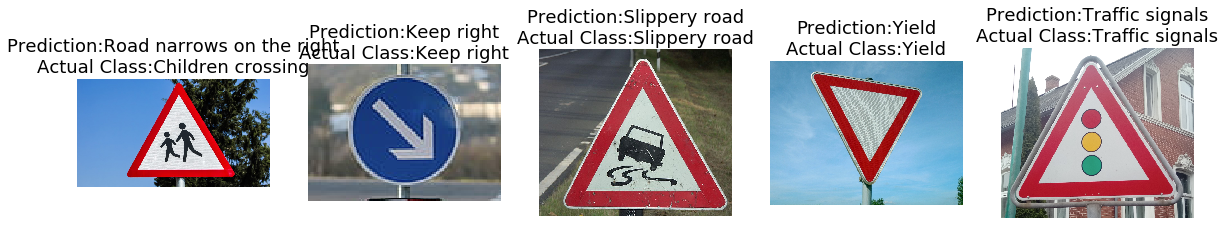

In [19]:
correct_classification_counter = 0

fig, axs = plt.subplots(1,5, figsize=(20,5))
for i, img in enumerate(X_new_test[:5]):
    axs[i].imshow(cv2.cvtColor(new_test['features'][i],cv2.COLOR_BGR2RGB))    
    axs[i].set_title('Prediction:' + class_names[str(np.argmax(predictions[i]))] + '\n'+'Actual Class:' + class_names[str(y_new_test[i])], fontsize=18)
    axs[i].axis('off')
    
    if np.argmax(predictions[i]) == y_new_test[i]:
        correct_classification_counter += 1    


plt.savefig('./output_images/test_new_images.jpg')



### Analyze Performance

In [20]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
accuracy = correct_classification_counter / len(X_new_test[:5])

print('Accuracy: ' + str(accuracy))

Accuracy: 0.8


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, we print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [21]:
tf.nn.top_k(predictions, k=5)

TopKV2(values=<tf.Tensor: shape=(6, 5), dtype=float32, numpy=
array([[9.7516251e-01, 2.2566535e-02, 1.6103191e-03, 6.5908866e-04,
        8.6174066e-07],
       [1.0000000e+00, 7.5325371e-11, 3.0620977e-12, 1.5109036e-12,
        1.1018201e-12],
       [9.9995255e-01, 2.2424736e-05, 1.5006304e-05, 7.0773649e-06,
        1.5214321e-06],
       [1.0000000e+00, 5.3004205e-14, 3.1965928e-17, 3.0654208e-17,
        3.0459396e-19],
       [9.8143709e-01, 1.8562889e-02, 6.3917388e-10, 4.4089538e-11,
        2.8501249e-13],
       [8.4094113e-01, 1.4466350e-01, 8.3759632e-03, 4.5135613e-03,
        1.3624051e-03]], dtype=float32)>, indices=<tf.Tensor: shape=(6, 5), dtype=int32, numpy=
array([[24, 20, 30, 28, 11],
       [38, 25,  5, 15, 36],
       [23, 20, 30, 19, 28],
       [13, 35, 12, 15, 28],
       [26, 18, 24, 38, 20],
       [38,  0, 26,  4, 17]], dtype=int32)>)

Image number 1 - Actual class: Children crossing
Model's top 5 classes: [24 20 30 28 11]
Model's top 5 softmax probabilities: [9.7516251e-01 2.2566535e-02 1.6103191e-03 6.5908866e-04 8.6174066e-07]

Model's top 5 classes with their probabilities:
- Road narrows on the right --> 0.9751625
- Dangerous curve to the right --> 0.022566535
- Beware of ice/snow --> 0.0016103191
- Children crossing --> 0.00065908866
- Right-of-way at the next intersection --> 8.6174066e-07


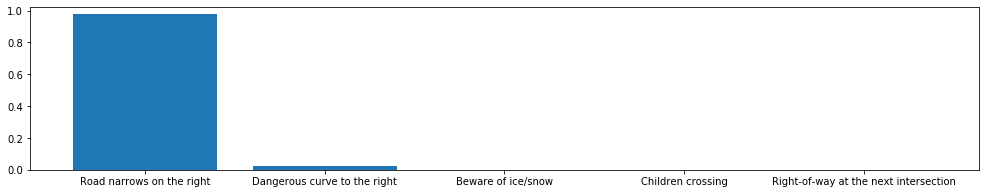

Image number 2 - Actual class: Keep right
Model's top 5 classes: [38 25  5 15 36]
Model's top 5 softmax probabilities: [1.0000000e+00 7.5325371e-11 3.0620977e-12 1.5109036e-12 1.1018201e-12]

Model's top 5 classes with their probabilities:
- Keep right --> 1.0
- Road work --> 7.532537e-11
- Speed limit (80km/h) --> 3.0620977e-12
- No vehicles --> 1.5109036e-12
- Go straight or right --> 1.1018201e-12


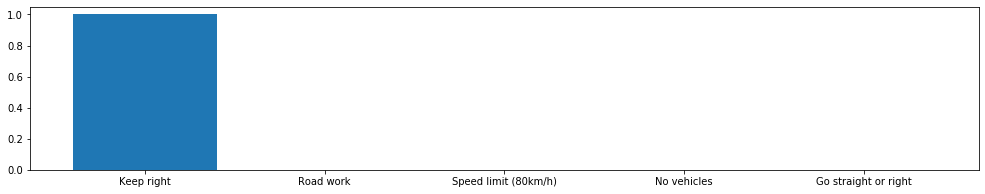

Image number 3 - Actual class: Slippery road
Model's top 5 classes: [23 20 30 19 28]
Model's top 5 softmax probabilities: [9.9995255e-01 2.2424736e-05 1.5006304e-05 7.0773649e-06 1.5214321e-06]

Model's top 5 classes with their probabilities:
- Slippery road --> 0.99995255
- Dangerous curve to the right --> 2.2424736e-05
- Beware of ice/snow --> 1.5006304e-05
- Dangerous curve to the left --> 7.077365e-06
- Children crossing --> 1.5214321e-06


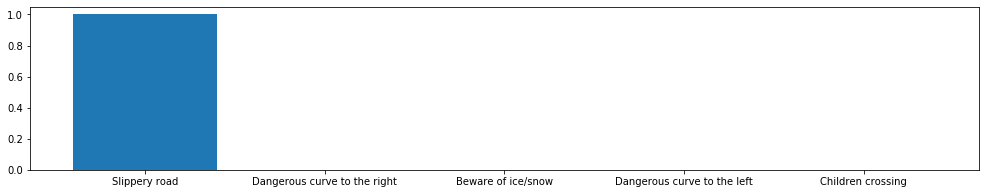

Image number 4 - Actual class: Yield
Model's top 5 classes: [13 35 12 15 28]
Model's top 5 softmax probabilities: [1.0000000e+00 5.3004205e-14 3.1965928e-17 3.0654208e-17 3.0459396e-19]

Model's top 5 classes with their probabilities:
- Yield --> 1.0
- Ahead only --> 5.3004205e-14
- Priority road --> 3.1965928e-17
- No vehicles --> 3.065421e-17
- Children crossing --> 3.0459396e-19


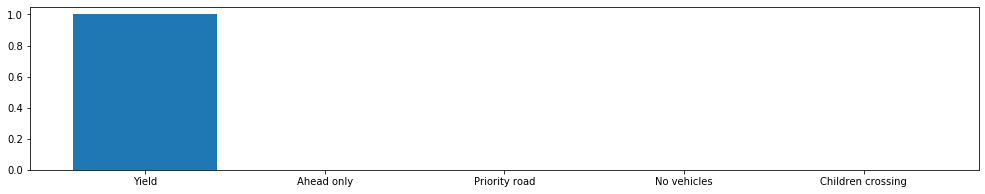

Image number 5 - Actual class: Traffic signals
Model's top 5 classes: [26 18 24 38 20]
Model's top 5 softmax probabilities: [9.8143709e-01 1.8562889e-02 6.3917388e-10 4.4089538e-11 2.8501249e-13]

Model's top 5 classes with their probabilities:
- Traffic signals --> 0.9814371
- General caution --> 0.018562889
- Road narrows on the right --> 6.391739e-10
- Keep right --> 4.4089538e-11
- Dangerous curve to the right --> 2.850125e-13


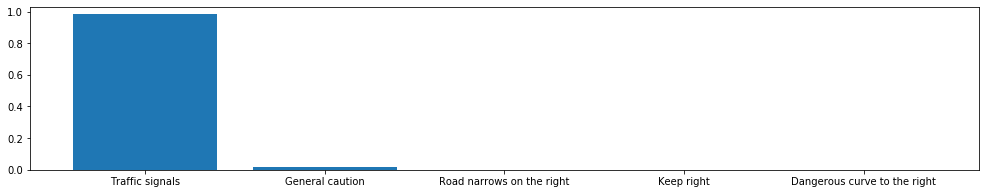

In [22]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
for i in range(len(predictions[:5])):
    top5_predictions = tf.nn.top_k(predictions[i], k=5)
    ind = top5_predictions.indices.numpy()
    val = top5_predictions.values.numpy()
    print('Image number '+ str(i+1) + ' - Actual class: ' + class_names[str(y_new_test[i])])
    print('Model\'s top 5 classes: '+ str(ind))
    print('Model\'s top 5 softmax probabilities: '+ str(val))
    
    print('\nModel\'s top 5 classes with their probabilities:')
    for j in range(5):
        print('- '+ class_names[str(ind[j])] + ' --> ' +str(val[j]))        
    
    fig, ax = plt.subplots(figsize=(17,3))
    classes = [class_names[str(i)] for i in ind] 
    probs = val
    ax.bar(classes,probs)
    plt.show()
    

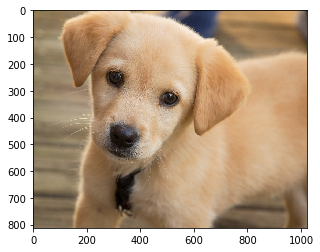

Model's top 5 classes: [38  0 26  4 17]
Model's top 5 softmax probabilities: [0.84094113 0.1446635  0.00837596 0.00451356 0.00136241]

Model's top 5 classes with their probabilities:
- Keep right --> 0.84094113
- Speed limit (20km/h) --> 0.1446635
- Traffic signals --> 0.008375963
- Speed limit (70km/h) --> 0.0045135613
- No entry --> 0.0013624051


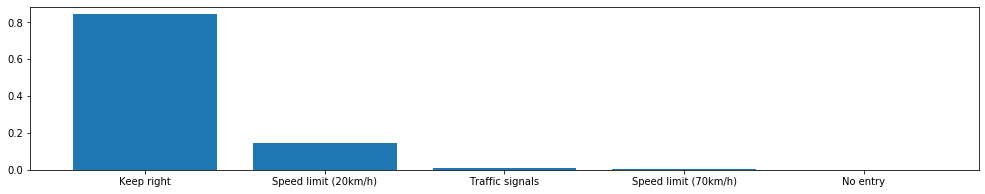

In [23]:
# Prediction for an image that is not a traffic sign. I chose an image of a puppy to test. 
fig, ax = plt.subplots()
plt.imshow(cv2.cvtColor(new_test['features'][5],cv2.COLOR_BGR2RGB))
plt.show()

top5_predictions = tf.nn.top_k(predictions[5], k=5)
ind = top5_predictions.indices.numpy()
val = top5_predictions.values.numpy()
print('Model\'s top 5 classes: '+ str(ind))
print('Model\'s top 5 softmax probabilities: '+ str(val))

print('\nModel\'s top 5 classes with their probabilities:')
for j in range(5):
    print('- '+class_names[str(ind[j])] + ' --> ' +str(val[j]))        

fig, ax = plt.subplots(figsize=(17,3))
classes = [class_names[str(i)] for i in ind] 
probs = val
ax.bar(classes,probs)
plt.show()


---

## Step 4: Visualize the Neural Network's State with Test Images

While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training the neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that 

In [24]:
### Visualize network's feature maps

# image_input: the test image being fed into the network to produce the feature maps
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, layer_name, activation_min=-1, activation_max=-1 ,plt_num=1):

    layer_output=model.get_layer(layer_name).output
    intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
    activation=intermediate_model.predict(image_input.reshape(1,32,32,1))

    featuremaps = activation.shape[3]

    plt.figure(plt_num, figsize=(20,5))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

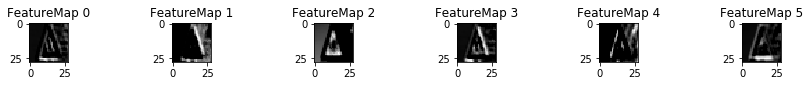

In [25]:
# outout of NN's first layer for sign #1 (Children Crossing)
model.layers[0]._name='layer0'
outputFeatureMap(X_new_test[0], 'layer0')

#plt.savefig('./output_images/first_layer_out_children.jpg')

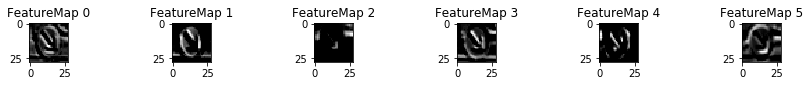

In [26]:
# outout of NN's first layer for sign #2 (Keep Right)
outputFeatureMap(X_new_test[1], 'layer0')

#plt.savefig('./output_images/first_layer_out_keep_right.jpg')

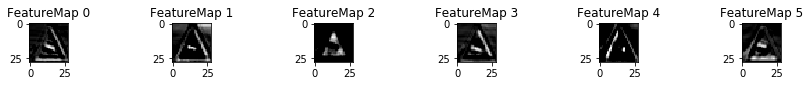

In [27]:
# outout of NN's first layer for sign #3 (Slipper Road)
outputFeatureMap(X_new_test[2], 'layer0')

#plt.savefig('./output_images/first_layer_out_slippery.jpg')

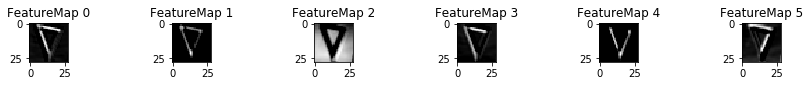

In [28]:
# outout of NN's first layer for sign #4 (Yield)
outputFeatureMap(X_new_test[3], 'layer0')

#plt.savefig('./output_images/first_layer_out_yield.jpg')

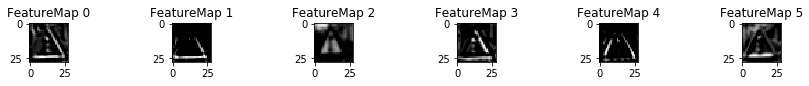

In [29]:
# outout of NN's first layer for sign #5 (Traffic Signals)
outputFeatureMap(X_new_test[4], 'layer0')

#plt.savefig('./output_images/first_layer_out_signals.jpg')

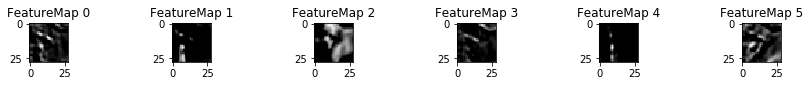

In [30]:
# outout of NN's first layer for sign #6 (Not a sign - an image of a puppy)
outputFeatureMap(X_new_test[5], 'layer0')

#plt.savefig('./output_images/first_layer_out_not_a_sign.jpg')

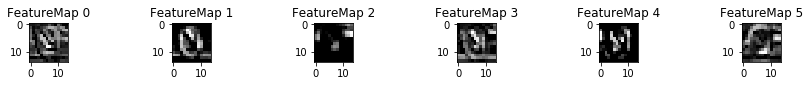

In [31]:
# outout of NN's second layer for sign #2 (Keep Right)
model.layers[1]._name='layer1'
outputFeatureMap(X_new_test[1], 'layer1')

#plt.savefig('./output_images/second_layer_out_keep_right.jpg')